# Improved Deep Mixture Density Network for Regional Wind Power Probabilistic Forecasting

## Import all the needed packages

In [1]:
# Basic Data Science Packages
import numpy as np
import pandas as pd

#TensorFlow packages for building DRNN layer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import SimpleRNN, Dense, Input, Reshape, LSTM, BatchNormalization, Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K

#Plotting graph
import matplotlib.pyplot as plt

#Normalization of data
from sklearn.preprocessing import StandardScaler

#Plotting Keras Model
from tensorflow.keras.utils import plot_model

#Utility Module for computing and displaying metrics
from utility_functions import metrics

import warnings
warnings.filterwarnings("ignore")

## Import the data and split into Train, Test and Validation
- Fetch the first 70% records as train and the rest 15% each as validation and test
    - 8711 * 70% = 6097 records from the start (Train)
    - 6097 + 1307 = 6098 to 7404 records as (Validation)
    - 7404 + 1307 = 7405 to 8711 records as (Test)

In [2]:
thesis_dataset = pd.read_csv('data/final_thesis_dataset.csv',parse_dates=[0], index_col=0)

#Extracting dataset into train, validation and test sets
train = thesis_dataset[:6097]
valid = thesis_dataset[6097:7404]
test = thesis_dataset[7404:]

scaler = StandardScaler()

#Extracting solar and wind X, y columns per set
X_solar_train = scaler.fit_transform(train[['SWTDN', 'SWGDN', 'T']])
y_solar_train = scaler.fit_transform(train['DE_solar_generation_actual'].values.reshape(-1,1))
X_solar_valid = scaler.fit_transform(valid[['SWTDN', 'SWGDN', 'T']])
y_solar_valid = scaler.fit_transform(valid['DE_solar_generation_actual'].values.reshape(-1,1))
X_solar_test = scaler.fit_transform(test[['SWTDN', 'SWGDN', 'T']])
y_solar_test = scaler.fit_transform(test['DE_solar_generation_actual'].values.reshape(-1,1))

X_wind_train = scaler.fit_transform(train[['v1', 'v2', 'v_50m', 'z0']])
y_wind_train = scaler.fit_transform(train['DE_wind_generation_actual'].values.reshape(-1,1))
X_wind_valid = scaler.fit_transform(valid[['v1', 'v2', 'v_50m', 'z0']])
y_wind_valid = scaler.fit_transform(valid['DE_wind_generation_actual'].values.reshape(-1,1))
X_wind_test = scaler.fit_transform(test[['v1', 'v2', 'v_50m', 'z0']])
y_wind_test = scaler.fit_transform(test['DE_wind_generation_actual'].values.reshape(-1,1))

## Creating a Mixture Density Layer from scratch

In [3]:
class MixtureDensity(Layer):
    #Defines custom layer attributes, and state variables that do not depend on input shapes.
    def __init__(self, kernelDim, numComponents, **kwargs):
        self.hiddenDim = 24
        self.kernelDim = kernelDim
        self.numComponents = numComponents
        self.outputDim = 1
        super(MixtureDensity, self).__init__(**kwargs)

    #This method can be used to create weights that depend on the shape of the input
    #__call__() inside keras will automatically build the layer during invocation by calling this method.
    def build(self, inputShape):
        self.inputDim = inputShape[1]
        self.Wh = K.variable(np.random.normal(scale=0.5,size=(self.inputDim, self.hiddenDim)))
        self.bh = K.variable(np.random.normal(scale=0.5,size=(self.hiddenDim)))
        self.Wo = K.variable(np.random.normal(scale=0.5,size=(self.hiddenDim, self.outputDim)))
        self.bo = K.variable(np.random.normal(scale=0.5,size=(self.outputDim)))

        self._trainable_weights = [self.Wh,self.bh,self.Wo,self.bo]

    #this performs the logic of applying the layer to the input tensors
    def call(self, x, mask=None):
        hidden = K.tanh(K.dot(x, self.Wh) + self.bh)
        output = K.dot(hidden,self.Wo) + self.bo
        return output

## Building a IDMDN using Deep Layer of BatchNorm and Density for Mixture Density.

In [4]:
model = Sequential()
model.add(BatchNormalization(input_shape=(3,)))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(MixtureDensity(-1, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 3)                 12        
_________________________________________________________________
dense (Dense)                (None, 128)               512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               5

## Compiling the model by passing adam optimizer, loss=MSE and fetching accuracy metrics

In [5]:
model.compile('adam', 'mse', ['accuracy'])
history = model.fit(X_solar_train, y_solar_train, epochs=15, validation_data = (X_solar_valid, y_solar_valid))

Epoch 1/15
191/191 [==============================] - 2s 7ms/step - loss: 1.1195 - accuracy: 0.0000e+00 - val_loss: 0.4444 - val_accuracy: 0.0000e+00
Epoch 2/15
191/191 [==============================] - 0s 2ms/step - loss: 0.1761 - accuracy: 0.0000e+00 - val_loss: 0.4050 - val_accuracy: 0.0000e+00
Epoch 3/15
191/191 [==============================] - 0s 2ms/step - loss: 0.1608 - accuracy: 0.0000e+00 - val_loss: 0.1574 - val_accuracy: 0.0000e+00
Epoch 4/15
191/191 [==============================] - 0s 2ms/step - loss: 0.1323 - accuracy: 0.0000e+00 - val_loss: 0.1538 - val_accuracy: 0.0000e+00
Epoch 5/15
191/191 [==============================] - 0s 2ms/step - loss: 0.1173 - accuracy: 0.0000e+00 - val_loss: 0.1311 - val_accuracy: 0.0000e+00
Epoch 6/15
191/191 [==============================] - 0s 2ms/step - loss: 0.1193 - accuracy: 0.0000e+00 - val_loss: 0.1467 - val_accuracy: 0.0000e+00
Epoch 7/15
191/191 [==============================] - 0s 2ms/step - loss: 0.1183 - accuracy: 0.0000e

In [6]:
model.evaluate(X_solar_test, y_solar_test)

41/41 [==============================] - 0s 715us/step - loss: 0.2468 - accuracy: 0.0000e+00


[0.24680361151695251, 0.0]

## Plotting Keras Model

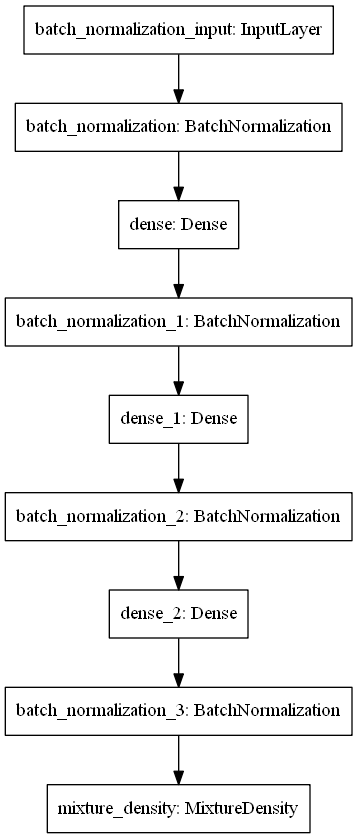

In [7]:
plot_model(
    model, to_file='figs/6-model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

## Plotting Model's Accuracy and Loss Metrics over Train and Validation sets for Solar

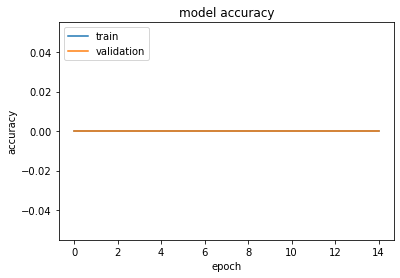

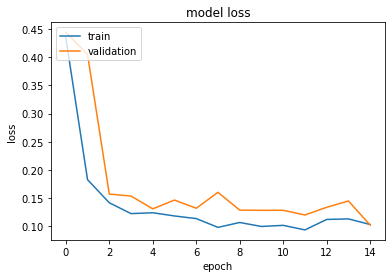

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Plotting Actual vs Predictions on the same plot

In [9]:
train_solar_pred = model.predict(X_solar_train)
val_solar_pred = model.predict(X_solar_valid)
test_solar_pred = model.predict(X_solar_test)

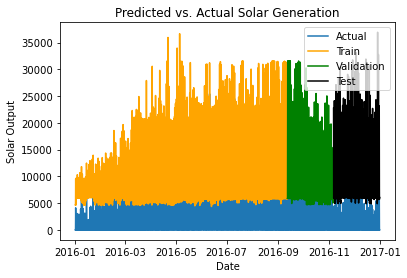

In [10]:
df = thesis_dataset[['DE_solar_generation_actual']]

train_df = train[['DE_solar_generation_actual']]
train_df.loc[:, 'DE_solar_generation_actual'] = scaler.inverse_transform(train_solar_pred)

valid_df = valid[['DE_solar_generation_actual']]
valid_df.loc[:, 'DE_solar_generation_actual'] = scaler.inverse_transform(val_solar_pred)

test_df = test[['DE_solar_generation_actual']]
test_df.loc[:, 'DE_solar_generation_actual'] = scaler.inverse_transform(test_solar_pred)

# Plot all predictions
inversetransform, =plt.plot(df, label = 'Actual')
train_solar_predx, =plt.plot(train_df, color='orange', label = 'Train')
val_solar_predx, =plt.plot(valid_df, color='green', label = 'Validation')
test_solar_predx, =plt.plot(test_df, color='black', label = 'Test')
plt.xlabel('Date')
plt.ylabel('Solar Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Solar Generation")
plt.show()

## Regression Metrics for Solar

In [11]:
metrics('drnn', test[['DE_solar_generation_actual']], test_solar_pred)

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
drnn,1193.601698,2639.700901,51.37802,3.93921,-0.256244


# Modelling and Fitting the model for Wind Dataset

In [12]:
model = Sequential()
model.add(BatchNormalization(input_shape=(4,)))
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(Dense(128))
model.add(BatchNormalization())
model.add(MixtureDensity(-1, 1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_4 (Batch (None, 4)                 16        
_________________________________________________________________
dense_3 (Dense)              (None, 128)               640       
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)              

In [13]:
model.compile('adam', 'mse', ['accuracy'])
history = model.fit(X_wind_train, y_wind_train, validation_data=(X_wind_valid, y_wind_valid), epochs=20)

Epoch 1/20
191/191 [==============================] - 1s 3ms/step - loss: 0.8657 - accuracy: 0.0000e+00 - val_loss: 0.8749 - val_accuracy: 0.0000e+00
Epoch 2/20
191/191 [==============================] - 0s 2ms/step - loss: 0.3248 - accuracy: 0.0000e+00 - val_loss: 0.7864 - val_accuracy: 0.0000e+00
Epoch 3/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2494 - accuracy: 0.0000e+00 - val_loss: 0.3241 - val_accuracy: 0.0000e+00
Epoch 4/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2280 - accuracy: 0.0000e+00 - val_loss: 0.2976 - val_accuracy: 0.0000e+00
Epoch 5/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2160 - accuracy: 0.0000e+00 - val_loss: 0.3287 - val_accuracy: 0.0000e+00
Epoch 6/20
191/191 [==============================] - 0s 2ms/step - loss: 0.2043 - accuracy: 0.0000e+00 - val_loss: 0.2566 - val_accuracy: 0.0000e+00
Epoch 7/20
191/191 [==============================] - 0s 2ms/step - loss: 0.1630 - accuracy: 0.0000e

In [14]:
model.evaluate(X_wind_test, y_wind_test)

41/41 [==============================] - 0s 746us/step - loss: 0.0682 - accuracy: 0.0000e+00


[0.06815018504858017, 0.0]

## Model's Accuracy and Loss for Wind Dataset

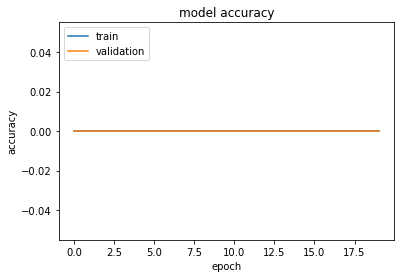

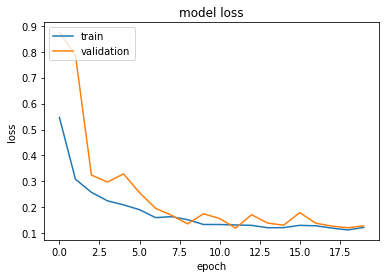

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Plotting Actual vs Predicted for Wind on same graph

In [16]:
train_wind_pred = model.predict(X_wind_train)
val_wind_pred = model.predict(X_wind_valid)
test_wind_pred = model.predict(X_wind_test)

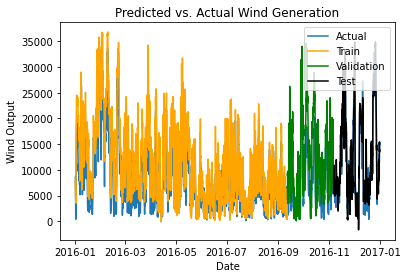

In [17]:
df = thesis_dataset[['DE_wind_generation_actual']]

train_df = train[['DE_wind_generation_actual']]
train_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(train_wind_pred)

valid_df = valid[['DE_wind_generation_actual']]
valid_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(val_wind_pred)

test_df = test[['DE_wind_generation_actual']]
test_df.loc[:, 'DE_wind_generation_actual'] = scaler.inverse_transform(test_wind_pred)

# Plot all predictions
inversetransform, =plt.plot(df, label = 'Actual')
train_wind_predx, =plt.plot(train_df, color='orange', label = 'Train')
val_wind_predx, =plt.plot(valid_df, color='green', label = 'Validation')
test_wind_predx, =plt.plot(test_df, color='black', label = 'Test')
plt.xlabel('Date')
plt.ylabel('Wind Output')
plt.legend(loc="upper right")
plt.title("Predicted vs. Actual Wind Generation")
plt.show()

## Regression Metrics for Wind

In [18]:
metrics('drnn', test[['DE_wind_generation_actual']], scaler.inverse_transform(test_wind_pred))

,MAE,MSE,RMSE,RMSLE,R2
model,,,,,
drnn,1839.575189,2256.715815,47.504903,3.860833,0.93185
